<a href="https://colab.research.google.com/github/piusAI/DeepLearning_Basic/blob/main/Chapter04_Last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Chapter 04

#### To do this!

- 01 Sigmoid, Softmax, CEE
- 02 Gradient, Sigmoid_gradient(sigmoid differentiation)
- 03 TwoNetwork


Avartar **S**tochastic **D**escent **G**radient


#### 01 sigmoid, Softmax, CEE, Gradient
02 gradient

In [29]:
import numpy as np

def sigmoid(x):
  return 1 / (1+ np.exp(-x))

def sigmoid_gradient(x):
  return sigmoid(x) * (1 - sigmoid(x) )

def softmax(x):
  if x.ndim==2:
    x= x-np.max(x,axis=1, keepdims=True)
    return np.exp(x) / np.sum(np.exp(x),axis=1, keepdims=True)
  x = x- np.max(x)
  return np.exp(x) / np.sum(np.exp(x))

def CEE(y,t):
  if y.ndim==1:
    y = y.reshape(y.shape[0], 1)
    t = t.reshape(t.shape[0], 1)
  batch_size = y.shape[0]
  return -np.sum(np.log(y[np.arange(batch_size), t]))/ batch_size

def _numerical_gradient_no_batch(f,x):
  h=1e-4
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val = x[idx]
    x[idx] = float(tmp_val)+h
    fxh1 = f(x)

    x[idx] = tmp_val - h
    fxh2 = f(x)

    grad[idx] = (fxh1-fxh2) / ( 2* h)
    x[idx] = tmp_val
    return grad
def numerical_gradient(f,X):
  if X.ndim == 1:
    return _numerical_gradient_no_batch(f,X)
  else:
    grad = np.zeros_like(X)
    for i, idx in enumerate(X):
      grad[i] = _numerical_gradient_no_batch(f,idx)
    return grad

####03 Two Network

In [27]:
class TwolayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std= 0.01):
    self.params = {}
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)
  def predict(self, x):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']

    a1 = np.dot(x, W1) + b1
    y1 = sigmoid(a1)
    a2 = np.dot(y1, W2) + b2
    y2 = softmax(a2)
    return y2
  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)

    if t.ndim != 1:
      t = np.argmax(t, axis=1)

    accuracy = np.sum(y == t) / float(x.shape[0])
    return accuracy

  def loss(self, x, t):
    y = self.predict(x)
    return CEE(y,t)

  def numerical_gradient(self, x, t):
    loss_w = lambda w : self.loss(x,t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_w, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_w, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_w, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_w, self.params['b2'])

    return grads

#역전파는 그냥 Pass
  def gradient(self, x, t):
    W1, W2 = self.params['W1'], self.params['W2']
    b1, b2 = self.params['b1'], self.params['b2']

    grads={}
    batch_num = x.shape[0]

    a1= np.dot(x,W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    if t.ndim ==1:
      t_one_hot = np.zeros_like(y)
      t_one_hot[np.arange(batch_num), t] = 1
      t = t_one_hot
    dy = (y-t) /batch_num
    grads ['W2'] = np.dot(z1.T, dy)
    grads['b2'] = np.sum(dy, axis=0)

    dz1 = np.dot(dy, W2.T)
    da1 = sigmoid_gradient(a1) * dz1
    grads['W1'] = np.dot(x.T, da1)
    grads['b1'] = np.sum(da1, axis=0)

    return grads

##여기서부터 다시

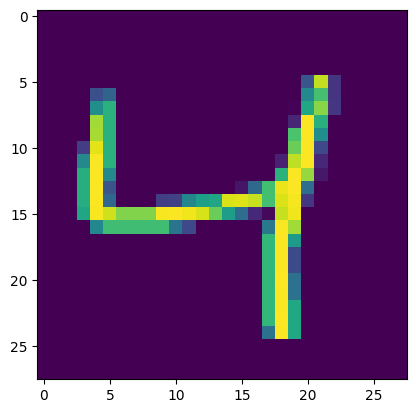

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(-1,784)
x_test = x_train.reshape(-1, 784)

plt.imshow(x_train[2].reshape(28,28))

train acc, test acc | : 0.11236666666666667, 0.1135
train acc, test acc | : 0.7707666666666667, 0.7819
train acc, test acc | : 0.8754166666666666, 0.8791
train acc, test acc | : 0.8975833333333333, 0.9004
train acc, test acc | : 0.9065666666666666, 0.9091
train acc, test acc | : 0.9134666666666666, 0.9152
train acc, test acc | : 0.9184, 0.9202
train acc, test acc | : 0.92265, 0.9242
train acc, test acc | : 0.92705, 0.9287
train acc, test acc | : 0.9306833333333333, 0.9311
train acc, test acc | : 0.9335666666666667, 0.9349
train acc, test acc | : 0.9367, 0.938
train acc, test acc | : 0.9389833333333333, 0.9385
train acc, test acc | : 0.9410166666666666, 0.9403
train acc, test acc | : 0.9439166666666666, 0.9415
train acc, test acc | : 0.94565, 0.9439
train acc, test acc | : 0.9472333333333334, 0.946


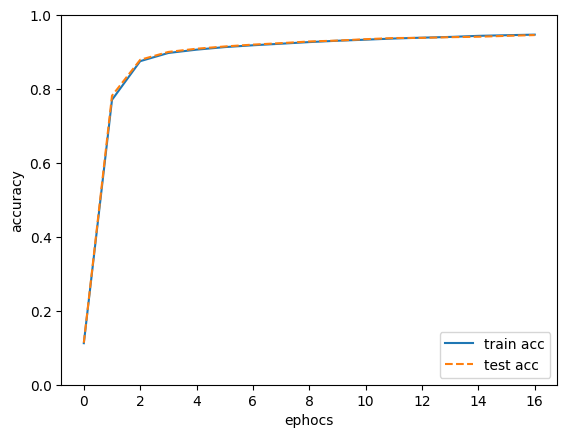

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

### Noramlize * Flatten
# x_test = x_test.flatten() / 255.0
# x_train = x_train.flatten() / 255.0
x_test =x_test.reshape(x_test.shape[0], -1) / 255.0
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
###

train_acc_list=[]
train_loss_list=[]
test_acc_list=[]

data_size = x_train.shape[0]
learning_rate = 0.1
iteration = 10000
batch_size = 100

iteration_per_epoch = max ( data_size / batch_size, 1)

network = TwolayerNet(input_size = 784, hidden_size = 50, output_size = 10)


for i in range(iteration) :
  batch_mask= np.random.choice(data_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]
  grad = network.gradient(x_batch, t_batch) #Check

  for key in ('W1', 'b1','W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

### re-again!
  if i % iteration_per_epoch ==0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

    print("train acc, test acc | : "+ str(train_acc) + ", " + str(test_acc))

markers = {'train':'o', 'test': 's'}
x= np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')

plt.xlabel('ephocs')
plt.ylabel('accuracy')

plt.ylim(0,1.0)
plt.legend(loc='lower right')
plt.show()

#### Load Mnist data

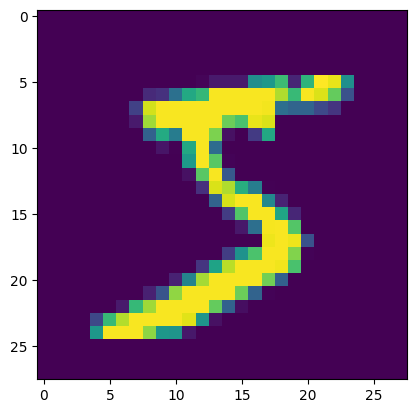

In [ ]:
import numpy as np
from keras.datasets import mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

import matplotlib.pyplot as plt
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)

plt.imshow(x_train[0].reshape(28,28))

train acc, test acc | 0.10386666666666666, 0.107


<ipython-input-21-adc30a7dced6>:21: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(y[np.arange(batch_size), t]))/ batch_size
<ipython-input-21-adc30a7dced6>:4: RuntimeWarning: overflow encountered in exp
  return 1 / 1+ np.exp(-x)
<ipython-input-21-adc30a7dced6>:11: RuntimeWarning: invalid value encountered in subtract
  x= x-np.max(x,axis=1, keepdims=True)


train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098
train acc, test acc | 0.09871666666666666, 0.098


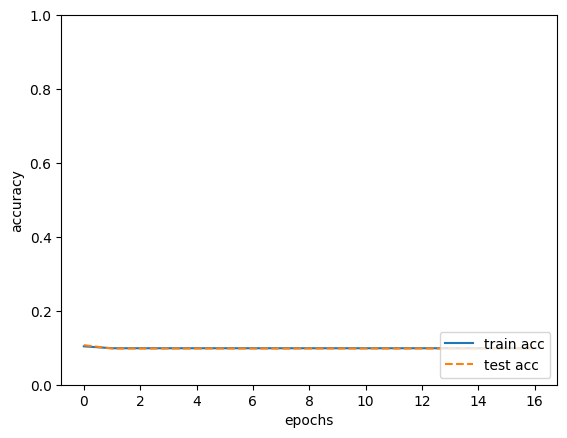

In [ ]:
import numpy as np
from keras.datasets import mnist

(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

train_loss_list = []

iters_num = 10000
train_size = x_train.shape[0]

batch_size = 100
learning_rate = 0.1

train_loss_list=[]
train_acc_list = []
test_acc_list=[]


network = TwolayerNet(input_size = 784, hidden_size = 50, output_size =10)
iters_per_epoch=max(train_size/batch_size,1)

for i in range(iters_num):
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]
  grad = network.gradient(x_batch, t_batch)

  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  if i % iters_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

markers = {'train': 'o', 'test': 's'}
x =np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

